In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop, Adagrad
from keras.utils import to_categorical

In [2]:
!wget https://github.com/Garasee/macine-learning/raw/main/datasets/car_eval.csv

--2024-06-13 17:43:04--  https://github.com/Garasee/macine-learning/raw/main/datasets/car_eval.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Garasee/macine-learning/main/datasets/car_eval.csv [following]
--2024-06-13 17:43:05--  https://raw.githubusercontent.com/Garasee/macine-learning/main/datasets/car_eval.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51884 (51K) [text/plain]
Saving to: ‘car_eval.csv’

car_eval.csv        100%[===================>]  50.67K  --.-KB/s    in 0.01s   

2024-06-13 17:43:05 (4.09 MB/s) - ‘car_eval.csv’ saved [51884/51884]



In [3]:
df = pd.read_csv('/content/car_eval.csv')

In [4]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [5]:
df.shape

(1727, 7)

In [6]:
def create_barplot(columns):
  counts = columns.value_counts()

  counts.plot(kind='bar')

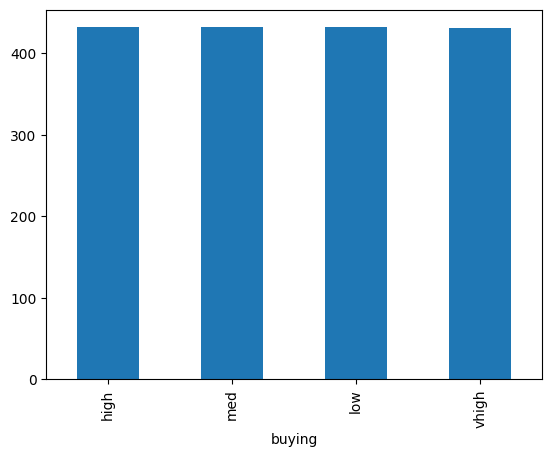

In [7]:
create_barplot(df['buying'])

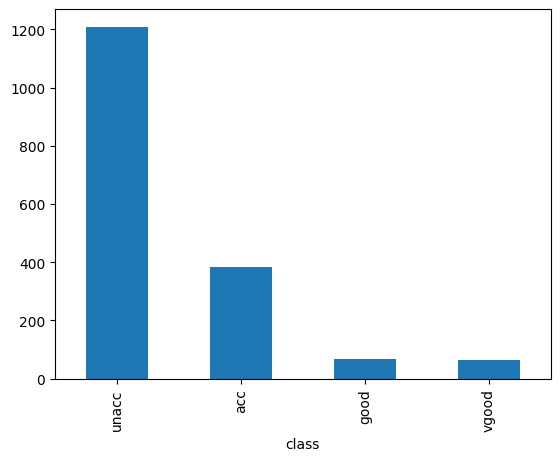

In [8]:
create_barplot(df['class'])

In [9]:
df['class'] = df['class'].replace(['good', 'vgood'], 'acc')

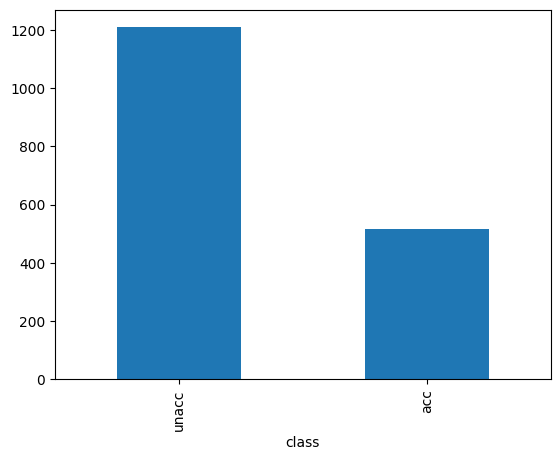

In [10]:
create_barplot(df['class'])

In [11]:
df.columns

Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'], dtype='object')

In [12]:
categorical_features = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [13]:
df.dtypes

buying      int64
maint       int64
doors       int64
persons     int64
lug_boot    int64
safety      int64
class       int64
dtype: object

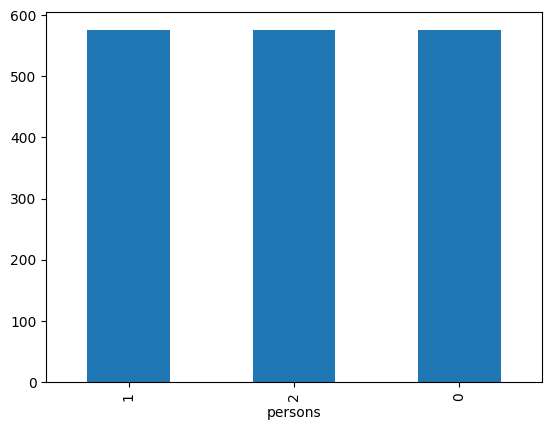

In [14]:
create_barplot(df['persons'])

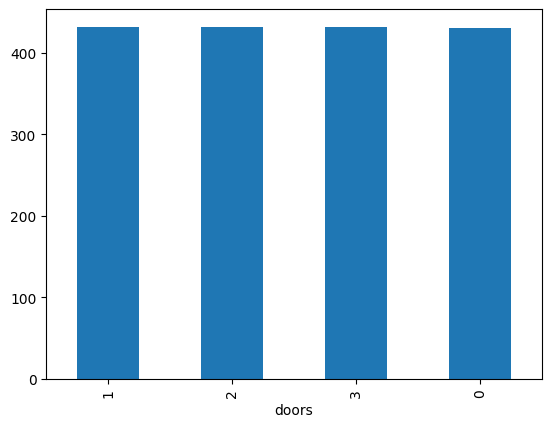

In [15]:
create_barplot(df['doors'])

## Resample and add split data

In [16]:
X = df.drop(columns='class')
y = df['class']

In [17]:
from imblearn.over_sampling import SMOTE

resampler = SMOTE(sampling_strategy='minority')

X, y = resampler.fit_resample(X, y)

In [18]:
y.value_counts()

class
1    1209
0    1209
Name: count, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [20]:
# y_train = to_categorical(y_train, num_classes=2)
# y_test = to_categorical(y_test, num_classes=2)

In [21]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1934, 6) (484, 6) (1934,) (484,)


In [22]:
y_test

410     1
199     1
1673    1
1124    1
2285    0
       ..
2206    0
727     0
281     1
2009    0
1612    0
Name: class, Length: 484, dtype: int64

## Modelling

Tensorflow

In [47]:
model = Sequential(
    [
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)

In [48]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [49]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    start_from_epoch=0,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

checkpoint_filepath = '/content/checkpoint.model.keras'

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [50]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    batch_size=4,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/100
484/484 [==============================] - 7s 10ms/step - loss: 0.5778 - accuracy: 0.7115 - val_loss: 0.5093 - val_accuracy: 0.7789 - lr: 1.0000e-04
Epoch 2/100
484/484 [==============================] - 3s 7ms/step - loss: 0.4382 - accuracy: 0.7989 - val_loss: 0.4762 - val_accuracy: 0.7851 - lr: 1.0000e-04
Epoch 3/100
484/484 [==============================] - 2s 5ms/step - loss: 0.3235 - accuracy: 0.8738 - val_loss: 0.2949 - val_accuracy: 0.8843 - lr: 1.0000e-04
Epoch 4/100
484/484 [==============================] - 3s 5ms/step - loss: 0.2274 - accuracy: 0.9286 - val_loss: 0.2318 - val_accuracy: 0.9153 - lr: 1.0000e-04
Epoch 5/100
484/484 [==============================] - 3s 5ms/step - loss: 0.1824 - accuracy: 0.9400 - val_loss: 0.2461 - val_accuracy: 0.8946 - lr: 1.0000e-04
Epoch 6/100
484/484 [==============================] - 4s 8ms/step - loss: 0.1631 - accuracy: 0.9426 - val_loss: 0.2003 - val_accuracy: 0.9318 - lr: 1.0000e-04
Epoch 7/100
484/484 [==================

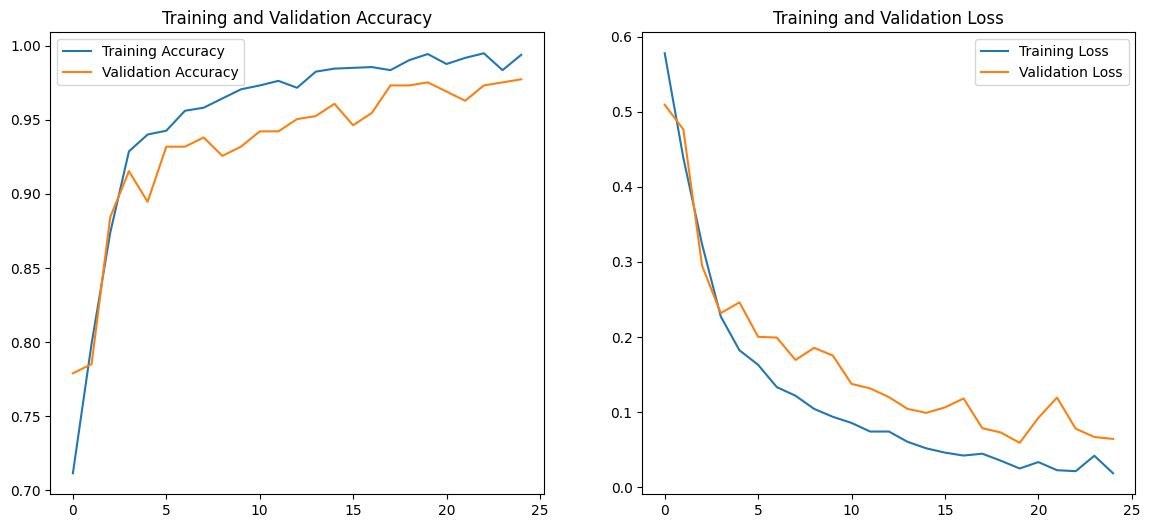

In [51]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs = range(len(acc))

plt.figure(figsize=(14, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Display the plots
plt.show()

In [52]:
import joblib

model.save('model_v1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
